In [1]:
%pip install  edge-ml

  Using cached edge_ml-0.3.3-py3-none-any.whl.metadata (6.7 kB)
Using cached edge_ml-0.3.3-py3-none-any.whl (7.6 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from edgeml import DatasetReceiver
import pandas as pd
import numpy as np

In [3]:
project=DatasetReceiver("https://beta.edge-ml.org","0aac4e12c96cb0f863ef585e9028c079")
project.loadData()

RuntimeError: Unauthorized

In [1]:
import pickle
pickle.dump(project, open("project.pkl","wb"))

NameError: name 'project' is not defined

In [4]:
import pickle
project=pickle.load(open("../project.pkl","rb"))

In [5]:
df=pd.concat([d.data.dropna().assign(**d.metaData) for d  in project.datasets if (d.name == "devicemotion" and d.data.shape[0]>0) ] )
df

,time,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,participantId,activity,mobile,browser
0,2024-05-04 06:37:51.267,1.3,-0.3,-2.9,1.1,3.7,7.1,-9.9,10.6,-25.299999,111f7,testing,UnknownPhone,Chrome
1,2024-05-04 06:37:51.284,0.9,-0.4,-3.2,0.1,3.4,6.8,-9.0,7.3,-32.099998,111f7,testing,UnknownPhone,Chrome
2,2024-05-04 06:37:51.300,-0.1,-0.7,-3.3,-0.1,3.2,6.8,0.0,0.3,-34.400002,111f7,testing,UnknownPhone,Chrome
3,2024-05-04 06:37:51.317,-0.4,-0.7,-3.2,-0.3,3.4,6.5,4.5,0.1,-32.000000,111f7,testing,UnknownPhone,Chrome
4,2024-05-04 06:37:51.334,-0.4,-0.7,-3.2,-0.3,3.6,6.1,7.2,0.3,-30.200001,111f7,testing,UnknownPhone,Chrome
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2024-05-07 12:03:58.362,-0.1,0.0,0.0,0.0,4.6,8.6,-0.8,4.1,0.400000,uksco,sitting,UnknownPhone,Chrome
125,2024-05-07 12:03:58.379,-0.1,0.0,0.0,0.0,4.6,8.6,-0.8,1.1,0.700000,uksco,sitting,UnknownPhone,Chrome
126,2024-05-07 12:03:58.396,-0.1,0.0,0.0,0.0,4.6,8.6,0.3,0.2,1.100000,uksco,sitting,UnknownPhone,Chrome
127,2024-05-07 12:03:58.413,-0.1,0.0,0.0,0.0,4.6,8.6,1.4,0.6,1.300000,uksco,sitting,UnknownPhone,Chrome


In [6]:
df2=pd.concat([df.drop(columns=["mobile","browser"]),pd.get_dummies(df[["browser"]])], axis=1)
df2.index=df.time
df2=df2.drop(columns="time")
df2["activity"],labels=df2["activity"].factorize()
df2

,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,participantId,activity,browser_Chrome,browser_Firefox
time,,,,,,,,,,,,,
2024-05-04 06:37:51.267,1.3,-0.3,-2.9,1.1,3.7,7.1,-9.9,10.6,-25.299999,111f7,0,True,False
2024-05-04 06:37:51.284,0.9,-0.4,-3.2,0.1,3.4,6.8,-9.0,7.3,-32.099998,111f7,0,True,False
2024-05-04 06:37:51.300,-0.1,-0.7,-3.3,-0.1,3.2,6.8,0.0,0.3,-34.400002,111f7,0,True,False
2024-05-04 06:37:51.317,-0.4,-0.7,-3.2,-0.3,3.4,6.5,4.5,0.1,-32.000000,111f7,0,True,False
2024-05-04 06:37:51.334,-0.4,-0.7,-3.2,-0.3,3.6,6.1,7.2,0.3,-30.200001,111f7,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07 12:03:58.362,-0.1,0.0,0.0,0.0,4.6,8.6,-0.8,4.1,0.400000,uksco,3,True,False
2024-05-07 12:03:58.379,-0.1,0.0,0.0,0.0,4.6,8.6,-0.8,1.1,0.700000,uksco,3,True,False
2024-05-07 12:03:58.396,-0.1,0.0,0.0,0.0,4.6,8.6,0.3,0.2,1.100000,uksco,3,True,False


In [7]:
labels


Index(['testing', 'standing', 'walking', 'sitting'], dtype='object')

In [8]:
df2.dtypes

acceleration.x                    float32
acceleration.y                    float32
acceleration.z                    float32
accelerationIncludingGravity.x    float32
accelerationIncludingGravity.y    float32
accelerationIncludingGravity.z    float32
rotationRate.alpha                float32
rotationRate.beta                 float32
rotationRate.gamma                float32
participantId                      object
activity                            int64
browser_Chrome                       bool
browser_Firefox                      bool
dtype: object

In [9]:
def mode(x): 
    return (x.mode()[0])


In [10]:
aggs={ **dict.fromkeys(df2.select_dtypes(exclude=[np.float32]).columns, [ lambda x : x.mode()[0]  ]),
      **dict.fromkeys(df2.select_dtypes(include=[np.float32]).columns, ["mean","var","min","max","median"])}

del(aggs["participantId"])
aggs

{'activity': [<function __main__.<lambda>(x)>],
 'browser_Chrome': [<function __main__.<lambda>(x)>],
 'browser_Firefox': [<function __main__.<lambda>(x)>],
 'acceleration.x': ['mean', 'var', 'min', 'max', 'median'],
 'acceleration.y': ['mean', 'var', 'min', 'max', 'median'],
 'acceleration.z': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.x': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.y': ['mean', 'var', 'min', 'max', 'median'],
 'accelerationIncludingGravity.z': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.alpha': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.beta': ['mean', 'var', 'min', 'max', 'median'],
 'rotationRate.gamma': ['mean', 'var', 'min', 'max', 'median']}

In [11]:
df3=df2.groupby("participantId").rolling("1s").agg(aggs)

In [12]:
df3

activity browser_Chrome browser_Firefox  \
                                      <lambda>       <lambda>        <lambda>   
participantId time                                                              
10280         2024-05-06 16:05:25.380      3.0            0.0             1.0   
              2024-05-06 16:05:25.382      3.0            0.0             1.0   
              2024-05-06 16:05:25.388      3.0            0.0             1.0   
              2024-05-06 16:05:25.388      3.0            0.0             1.0   
              2024-05-06 16:05:25.388      3.0            0.0             1.0   
...                                        ...            ...             ...   
uksco         2024-05-07 12:03:58.362      3.0            1.0             0.0   
              2024-05-07 12:03:58.379      3.0            1.0             0.0   
              2024-05-07 12:03:58.396      3.0            1.0             0.0   
              2024-05-07 12:03:58.413      3.0            1.0             0.0   
              2024-05-07 12:03:58.429      3.0            1.0             0.0   

                                      acceleration.x                       \
                                                mean       var   min  max   
participantId time                                                          
10280         2024-05-06 16:05:25.380       0.000000       NaN  0.00  0.0   
              2024-05-06 16:05:25.382      -0.005000  0.000050 -0.01  0.0   
              2024-05-06 16:05:25.388      -0.003333  0.000033 -0.01  0.0   
              2024-05-06 16:05:25.388      -0.002500  0.000025 -0.01  0.0   
              2024-05-06 16:05:25.388      -0.002000  0.000020 -0.01  0.0   
...                                              ...       ...   ...  ...   
uksco         2024-05-07 12:03:58.362      -0.014754  0.006612 -0.20  0.1   
              2024-05-07 12:03:58.379      -0.016667  0.006836 -0.20  0.1   
              2024-05-07 12:03:58.396      -0.018333  0.006946 -0.20  0.1   
              2024-05-07 12:03:58.413      -0.021667  0.006811 -0.20  0.1   
              2024-05-07 12:03:58.429      -0.025000  0.006653 -0.20  0.1   

                                             acceleration.y            ...  \
                                      median           mean       var  ...   
participantId time                                                     ...   
10280         2024-05-06 16:05:25.380  0.000       0.020000       NaN  ...   
              2024-05-06 16:05:25.382 -0.005       0.025000  0.000050  ...   
              2024-05-06 16:05:25.388  0.000       0.023333  0.000033  ...   
              2024-05-06 16:05:25.388  0.000       0.022500  0.000025  ...   
              2024-05-06 16:05:25.388  0.000       0.022000  0.000020  ...   
...                                      ...            ...       ...  ...   
uksco         2024-05-07 12:03:58.362  0.000      -0.014754  0.002612  ...   
              2024-05-07 12:03:58.379  0.000      -0.018333  0.002201  ...   
              2024-05-07 12:03:58.396  0.000      -0.018333  0.002201  ...   
              2024-05-07 12:03:58.413  0.000      -0.018333  0.002201  ...   
              2024-05-07 12:03:58.429  0.000      -0.018333  0.002201  ...   

                                      rotationRate.beta                   \
                                                   mean        var   min   
participantId time                                                         
10280         2024-05-06 16:05:25.380         -0.030000        NaN -0.03   
              2024-05-06 16:05:25.382         -0.030000   0.000000 -0.03   
              2024-05-06 16:05:25.388         -0.030000   0.000000 -0.03   
              2024-05-06 16:05:25.388         -0.030000   0.000000 -0.03   
              2024-05-06 16:05:25.388         -0.030000   0.000000 -0.03   
...                                                 ...        ...   ...   
uksco         2024-05-07 12:03:58.362          

In [13]:
df4=df3.copy()

df4.index=df3.index.droplevel(1)
df4=df4.reset_index()

df4.dropna(inplace=True)
df4

participantId activity browser_Chrome browser_Firefox acceleration.x  \
                     <lambda>       <lambda>        <lambda>           mean   
1              10280      3.0            0.0             1.0      -0.005000   
2              10280      3.0            0.0             1.0      -0.003333   
3              10280      3.0            0.0             1.0      -0.002500   
4              10280      3.0            0.0             1.0      -0.002000   
5              10280      3.0            0.0             1.0      -0.001667   
...              ...      ...            ...             ...            ...   
131791         uksco      3.0            1.0             0.0      -0.014754   
131792         uksco      3.0            1.0             0.0      -0.016667   
131793         uksco      3.0            1.0             0.0      -0.018333   
131794         uksco      3.0            1.0             0.0      -0.021667   
131795         uksco      3.0            1.0             0.0      -0.025000   

                                   acceleration.y  ... rotationRate.beta  \
             var   min  max median           mean  ...              mean   
1       0.000050 -0.01  0.0 -0.005       0.025000  ...         -0.030000   
2       0.000033 -0.01  0.0  0.000       0.023333  ...         -0.030000   
3       0.000025 -0.01  0.0  0.000       0.022500  ...         -0.030000   
4       0.000020 -0.01  0.0  0.000       0.022000  ...         -0.030000   
5       0.000017 -0.01  0.0  0.000       0.021667  ...         -0.030000   
...          ...   ...  ...    ...            ...  ...               ...   
131791  0.006612 -0.20  0.1  0.000      -0.014754  ...          0.673771   
131792  0.006836 -0.20  0.1  0.000      -0.018333  ...          0.763333   
131793  0.006946 -0.20  0.1  0.000      -0.018333  ...          0.811667   
131794  0.006811 -0.20  0.1  0.000      -0.018333  ...          0.803333   
131795  0.006653 -0.20  0.1  0.000      -0.018333  ...          0.788333   

                                      rotationRate.gamma                  \
              var   min    max median               mean       var   min   
1        0.000000 -0.03  -0.03  -0.03          -0.060000  0.000000 -0.06   
2        0.000000 -0.03  -0.03  -0.03          -0.060000  0.000000 -0.06   
3        0.000000 -0.03  -0.03  -0.03          -0.060000  0.000000 -0.06   
4        0.000000 -0.03  -0.03  -0.03          -0.060000  0.000000 -0.06   
5        0.000000 -0.03  -0.03  -0.03          -0.060000  0.000000 -0.06   
...           ...   ...    ...    ...                ...       ...   ...   
131791  17.194634 -9.90  14.80   0.40          -0.057377  2.263153 -3.90   
131792  17.256938 -9.90  14.80   0.45          -0.015000  2.282314 -3.90   
131793  17.056641 -9.90  14.80   0.45           0.021667  2.282065 -3.90   
131794  17.055921 -9.90  14.80   0.45           0.080000  2.222644 -3.90   
131795  17.060370 -9.90  14.80   0.40           0.150000  2.192034 -3.90   

                     
         max median  
1      -0.06  -0.06  
2      -0.06  -0.06  
3      -0.06  -0.06  
4      -0.06  -0.06  
5      -0.06  -0.06  
...      ...    ...  
131791  2.10   0.40  
131792  2.10   0.40  
131793  2.10   0.40  
131794  2.10   0.45  
131795  2.10   0.50  

[131699 rows x 49 columns]

In [14]:
df5=df4.sample(1000)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

# Assume df is a pandas dataframe with features and labels
X = df5.drop(['activity','participantId'], axis=1) # Features
y = df5['activity'] # Labels
groups = df5['participantId'] # Group identifiers

from sklearn.model_selection import cross_val_score
scores=cross_val_score(clf, X, y, cv=LeaveOneGroupOut(), groups=groups, scoring="f1_macro")
scores.mean()



/tmp/ipykernel_424/3902989916.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df5.drop(['activity','participantId'], axis=1) # Features
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwa

0.4442380267218277

In [36]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# rfecv = RFECV(estimator=clf, step=1, cv=LeaveOneGroupOut(), groups=groups, scoring='f1_macro')
rfecv = RFECV(estimator=clf, step=1, scoring='f1_macro')
rfecv = rfecv.fit(X, y) 

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

In [37]:
import matplotlib.pyplot as plt

cv_results = pd.DataFrame(rfecv.cv_results_)
cv_results

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.568882,0.033451,0.550061,0.598481,0.511601,0.591061,0.593206
1,0.723945,0.081095,0.828941,0.747803,0.578608,0.728330,0.736043
2,0.813545,0.055138,0.824676,0.883896,0.714268,0.814897,0.829989
3,0.821059,0.040140,0.821118,0.892317,0.772663,0.795933,0.823263
4,0.836150,0.058823,0.810209,0.931655,0.750423,0.840558,0.847904
5,0.836239,0.053565,0.826921,0.921914,0.764414,0.863554,0.804395
6,0.842686,0.045614,0.830890,0.916445,0.774118,0.853078,0.838902
7,0.843907,0.048195,0.820927,0.922187,0.786007,0.816903,0.873508
8,0.846177,0.039714,0.814439,0.907323,0.810972,0.818387,0.879764
9,0.851746,0.037827,0.831518,0.919211,0.805105,0.848442,0.854452


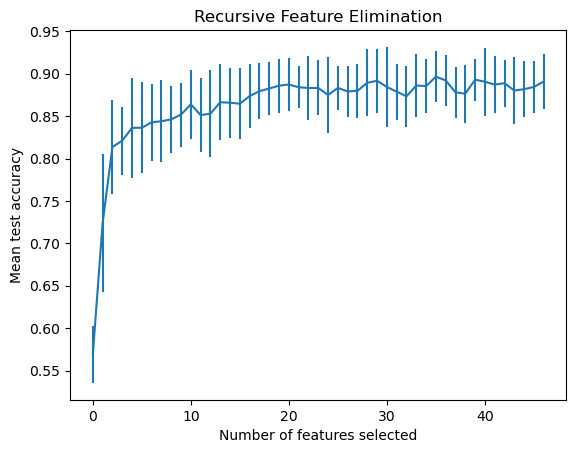

In [39]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results.index,
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination")
plt.show()

In [68]:
df6=pd.concat([df4[rfecv.get_feature_names_out(X.columns)],df4[("activity","<lambda>")]],axis=1)
df6

acceleration.x       acceleration.y                         \
                  var   min           mean       var   min median   
1            0.000050 -0.01       0.025000  0.000050  0.02  0.025   
2            0.000033 -0.01       0.023333  0.000033  0.02  0.020   
3            0.000025 -0.01       0.022500  0.000025  0.02  0.020   
4            0.000020 -0.01       0.022000  0.000020  0.02  0.020   
5            0.000017 -0.01       0.021667  0.000017  0.02  0.020   
...               ...   ...            ...       ...   ...    ...   
131791       0.006612 -0.20      -0.014754  0.002612 -0.10  0.000   
131792       0.006836 -0.20      -0.018333  0.002201 -0.10  0.000   
131793       0.006946 -0.20      -0.018333  0.002201 -0.10  0.000   
131794       0.006811 -0.20      -0.018333  0.002201 -0.10  0.000   
131795       0.006653 -0.20      -0.018333  0.002201 -0.10  0.000   

       acceleration.z       accelerationIncludingGravity.x            ...  \
                  var   max                           mean       var  ...   
1            0.000000  0.01                       0.025000  0.000050  ...   
2            0.000033  0.01                       0.026667  0.000033  ...   
3            0.000033  0.01                       0.027500  0.000025  ...   
4            0.000030  0.01                       0.028000  0.000020  ...   
5            0.000027  0.01                       0.028333  0.000017  ...   
...               ...   ...                            ...       ...  ...   
131791       0.029372  0.40                       0.172131  0.009044  ...   
131792       0.029658  0.40                       0.165000  0.009093  ...   
131793       0.029658  0.40                       0.160000  0.009220  ...   
131794       0.029658  0.40                       0.155000  0.009297  ...   
131795       0.029658  0.40                       0.150000  0.009322  ...   

       rotationRate.beta                         rotationRate.gamma            \
                    mean        var   min    max               mean       var   
1              -0.030000   0.000000 -0.03  -0.03          -0.060000  0.000000   
2              -0.030000   0.000000 -0.03  -0.03          -0.060000  0.000000   
3              -0.030000   0.000000 -0.03  -0.03          -0.060000  0.000000   
4              -0.030000   0.000000 -0.03  -0.03          -0.060000  0.000000   
5              -0.030000   0.000000 -0.03  -0.03          -0.060000  0.000000   
...                  ...        ...   ...    ...                ...       ...   
131791          0.673771  17.194634 -9.90  14.80          -0.057377  2.263153   
131792          0.763333  17.256938 -9.90  14.80          -0.015000  2.282314   
131793          0.811667  17.056641 -9.90  14.80           0.021667  2.282065   
131794          0.803333  17.055921 -9.90  14.80           0.080000  2.222644   
131795          0.788333  17.060370 -9.90  14.80           0.150000  2.192034   

                          activity  
         min   max median <lambda>  
1      -0.06 -0.06  -0.06      3.0  
2      -0.06 -0.06  -0.06      3.0  
3      -0.06 -0.06  -0.06      3.0  
4      -0.06 -0.06  -0.06      3.0  
5      -0.06 -0.06  -0.06      3.0  
...      ...   ...    ...      ...  
131791 -3.90  2.10   0.40      3.0  
131792 -3.90  2.10   0.40      3.0  
131793 -3.90  2.10   0.40      3.0  
131794 -3.90  2.10   0.45      3.0  
131795 -3.90  2.10   0.50      3.0  

[131699 rows x 37 columns]

In [82]:
pickle.dump(df6,open("../features.pkl","wb"))